In [1]:
import tensorflow as tf
import numpy as np
import tensorflow.keras as keras
import pandas as pd
import os
from keras import layers

from data_processing import *
from training_utils import *

from train_config import *


os.environ["TF_GPU_ALLOCATOR"] = "cuda_malloc_async"

CONFIG = get_config()[0]

2024-04-12 18:09:24.496025: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-12 18:09:24.534485: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX_VNNI, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
CONFIG

{'DATA_PATH': 'data/flickr30k_images/',
 'IMAGES_PATH': 'data/flickr30k_images/flickr30k_images/',
 'IMAGE_SIZE': (224, 224),
 'VAL_FRACTION': 0.05,
 'SEQ_LENGTH': 32,
 'VOCAB_SIZE': 10000,
 'BATCH_SIZE': 128,
 'EPOCHS': 20,
 'STRIP_CHARS': '!"#$%&\'()*+,-./:;=?@[\\]^_`{|}~',
 'EMBED_DIM': 512,
 'FF_DIM': 256,
 'ENC_HEADS': 2,
 'DEC_HEADS': 2,
 'LR': 0.001,
 'ARTIFACT_DIR': 'artifacts'}

In [3]:
captionings_df = pd.read_csv(os.path.join(DATA_PATH, "results.csv"), sep="|").dropna()
captionings_df.columns = ["image_name", "comment_number", "comment"]
captionings_df["image_name"] = IMAGES_PATH + "/" + captionings_df["image_name"] 


#ADDING START AND END special tokens
captionings_df["comment"] = "<START> " + captionings_df["comment"] + "<END>"
captionings_df.head(10)

,image_name,comment_number,comment
0,data/flickr30k_images/flickr30k_images//100009...,0,<START> Two young guys with shaggy hair look ...
1,data/flickr30k_images/flickr30k_images//100009...,1,"<START> Two young , White males are outside n..."
2,data/flickr30k_images/flickr30k_images//100009...,2,<START> Two men in green shirts are standing ...
3,data/flickr30k_images/flickr30k_images//100009...,3,<START> A man in a blue shirt standing in a g...
4,data/flickr30k_images/flickr30k_images//100009...,4,<START> Two friends enjoy time spent together...
5,data/flickr30k_images/flickr30k_images//100024...,0,<START> Several men in hard hats are operatin...
6,data/flickr30k_images/flickr30k_images//100024...,1,<START> Workers look down from up above on a ...
7,data/flickr30k_images/flickr30k_images//100024...,2,<START> Two men working on a machine wearing ...
8,data/flickr30k_images/flickr30k_images//100024...,3,<START> Four men on top of a tall structure ....
9,data/flickr30k_images/flickr30k_images//100024...,4,<START> Three men on a large rig .<END>


**IMPORTANT NOTE: to make our model learn when to stop generating, we need to add <END> token in position of SEQ_LENGHT**

In [4]:
#Shuffle df
captionings_df = captionings_df.sample(frac=1,
                                       random_state=42,
                                       replace=False,
                                       )


n_train_examples = int(len(captionings_df) * (1 - VAL_FRACTION))

train_captionings_df = captionings_df[ : n_train_examples]
val_captionings_df = captionings_df[n_train_examples : ]

print("Train image-text examples: ", train_captionings_df.shape[0])
print("Validation image-text examples: ", val_captionings_df.shape[0])

#save splits
train_captionings_df.to_csv("splits/train_captions.csv", index=False)
val_captionings_df.to_csv("splits/val_captions.csv", index=False)

Train image-text examples:  150968
Validation image-text examples:  7946


In [5]:


tokenizer = build_tokenizer(vocab_size=VOCAB_SIZE, seq_len=SEQ_LENGTH)
tokenizer.adapt(train_captionings_df["comment"].tolist())

def process_input(img_path, captions):
    return decode_and_resize(img_path, IMAGE_SIZE), tf.reshape(tokenizer(captions), shape=(1, SEQ_LENGTH))

def make_dataset(images, captions):
    dataset = tf.data.Dataset.from_tensor_slices((images, captions))
    dataset = dataset.shuffle(BATCH_SIZE * 8)
    dataset = dataset.map(process_input, num_parallel_calls=AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)

    return dataset


2024-04-12 18:09:31.383486: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-12 18:09:31.407562: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-12 18:09:31.407674: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [6]:
train_dataset = make_dataset(train_captionings_df["image_name"].tolist(),
                             train_captionings_df["comment"].tolist())

val_dataset = make_dataset(train_captionings_df["image_name"].tolist(),
                             train_captionings_df["comment"].tolist())


In [7]:
for img, cap in val_dataset.take(1):
    print(img.shape, cap.shape)

(128, 224, 224, 3) (128, 1, 32)


In [8]:
from model import TransformerDecoderBlock, TransformerEncoderBlock, ImageCaptioningModel, get_cnn_model

In [21]:
base_model = keras.applications.efficientnet.EfficientNetB1(
        input_shape=(*IMAGE_SIZE, 3),
        include_top=False,
        weights="imagenet",
    )

cnn = get_cnn_model(base_model)

encoder = TransformerEncoderBlock(
    embed_dim=EMBED_DIM, dense_dim=FF_DIM, num_heads=ENC_HEADS
)
decoder = TransformerDecoderBlock(
    embed_dim=EMBED_DIM, ff_dim=FF_DIM, num_heads=DEC_HEADS, 
)

caption_model = ImageCaptioningModel(
    cnn_model=cnn,
    encoder=encoder, 
    decoder=decoder
)





### Callbacks


In [25]:

tensorboard = keras.callbacks.TensorBoard(log_dir=os.path.join(CONFIG["ARTIFACT_DIR"],"tensorboard_logs"))

bckup = keras.callbacks.BackupAndRestore(
    os.path.join(CONFIG["ARTIFACT_DIR"],"train_backup"), save_freq='epoch', delete_checkpoint=True
)

early_stopping = keras.callbacks.EarlyStopping(patience=2,
                                               verbose=1)


In [28]:
CONFIG["LR"]

0.001

In [34]:
X_batch, y_batch = next(iter(train_dataset.take(1))) #SANITY CHECK


cross_entropy = keras.losses.SparseCategoricalCrossentropy(
    from_logits=False,
    reduction="none"
)


caption_model.compile(optimizer=keras.optimizers.Adam(CONFIG["LR"]), loss=cross_entropy)

In [35]:
history = caption_model.fit(train_dataset,
                            validation_data=val_dataset, 
                            epochs=CONFIG["EPOCHS"],
                            callbacks=[tensorboard, bckup, early_stopping])

Epoch 1/20


2024-04-12 12:50:13.461477: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8902
2024-04-12 12:50:13.479011: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1180/1180 [==============================] - 311s 262ms/step - loss: 3.7845 - acc: 0.2926 - val_loss: 3.1432 - val_acc: 0.3743
Epoch 2/20
1180/1180 [==============================] - 318s 270ms/step - loss: 3.2993 - acc: 0.3555 - val_loss: 2.9544 - val_acc: 0.3890
Epoch 3/20
1180/1180 [==============================] - 328s 278ms/step - loss: 3.1623 - acc: 0.3669 - val_loss: 2.8334 - val_acc: 0.4008
Epoch 4/20
1180/1180 [==============================] - 335s 284ms/step - loss: 3.0756 - acc: 0.3750 - val_loss: 2.7541 - val_acc: 0.4082
Epoch 5/20
1180/1180 [==============================] - 334s 283ms/step - loss: 3.0139 - acc: 0.3812 - val_loss: 2.7110 - val_acc: 0.4130
Epoch 6/20
1180/1180 [==============================] - 341s 289ms/step - loss: 2.9711 - acc: 0.3851 - val_loss: 2.6674 - val_acc: 0.4173
Epoch 7/20
1180/1180 [==============================] - 342s 290ms/step - loss: 2.9353 - acc: 0.3883 - val_loss: 2.6189 - val_acc: 0.4215
Epoch 8/20
1180/1180 [=======================

In [38]:
from training_utils import save_training_history

In [39]:
save_training_history(history, os.path.join(CONFIG["ARTIFACT_DIR"],"trainhistory.csv"))

Training history saved to:  artifacts/trainhistory.csv


In [40]:
#save
caption_model.save_weights(os.path.join(CONFIG["ARTIFACT_DIR"],"model_weights.h5"))

In [43]:


# from training_utils import load_trained_model_weights



# new_model = load_trained_model_weights(os.path.join(CONFIG["ARTIFACT_DIR"],"model_weights.h5"))

In [45]:
caption_model.summary()

ValueError: This model has not yet been built. Build the model first by calling `build()` or by calling the model on a batch of data.

In [46]:

caption_model.evaluate(X_batch, y_batch)

4/4 [==============================] - 0s 37ms/step - loss: 2.5885 - acc: 0.4253


[2.5885472297668457, 0.4234652817249298]

In [27]:
import gc

In [28]:
gc.collect()

31068

In [9]:
new_model = load_trained_model_weights("artifacts/model_weights.h5", CONFIG)

In [10]:
caption_model = new_model

In [17]:
vocab = tokenizer.get_vocabulary()
index_lookup = dict(zip(range(len(vocab)), vocab))
max_decoded_sentence_length = SEQ_LENGTH - 1
valid_images = val_captionings_df.iloc[1: 100]["image_name"].to_list()

import matplotlib.pyplot as plt
def generate_caption():
    # Select a random image from the validation dataset
    sample_img = np.random.choice(valid_images)

    # Read the image from the disk
    sample_img = decode_and_resize(sample_img, IMAGE_SIZE)
    img = sample_img.numpy().clip(0, 255).astype(np.uint8)
    plt.figure(figsize=(8, 8))
    plt.imshow(img / 255.0)
    plt.show()

    # Pass the image to the CNN
    img = tf.expand_dims(sample_img, 0)
    
    img = caption_model.cnn_model(img)

    
    
    # Pass the image features to the Transformer encoder
    encoded_img = caption_model.encoder(img, training=False)

    # Generate the caption using the Transformer decoder
    decoded_caption = "<start> "
    for i in range(max_decoded_sentence_length):
        tokenized_caption = tokenizer([decoded_caption])[:, :-1]
        mask = tf.math.not_equal(tokenized_caption, 0)
        predictions = caption_model.decoder(
            tokenized_caption, encoded_img, training=False, mask=mask
        )
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = index_lookup[sampled_token_index]
        if sampled_token == "<end>":
            break
        decoded_caption += " " + sampled_token

    decoded_caption = decoded_caption.replace("<start> ", "")
    decoded_caption = decoded_caption.replace("<end>", "").strip()
    print("Predicted Caption: ", decoded_caption)

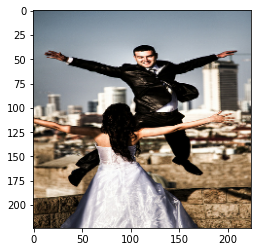

Predicted Caption:  a woman in a white dress is performing a trick


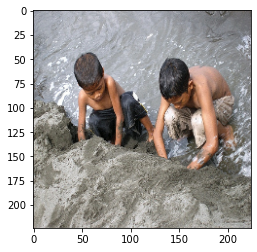

Predicted Caption:  two boys are digging a hole in the sand


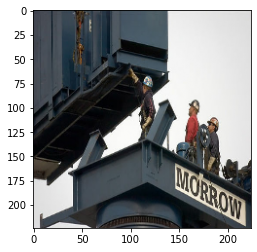

Predicted Caption:  a man in a blue shirt is standing on a roof


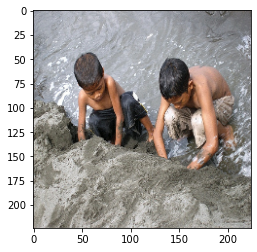

Predicted Caption:  two boys are digging a hole in the sand


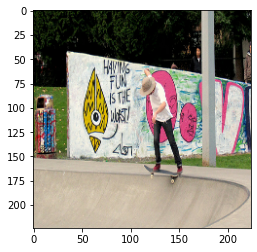

Predicted Caption:  a man in a white shirt and a blue jeans is skateboarding on a wall


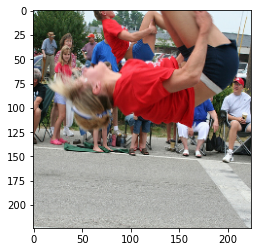

Predicted Caption:  a group of people are dancing in the street


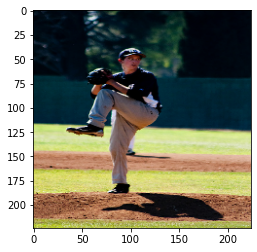

Predicted Caption:  a baseball player in a white uniform is running to the base


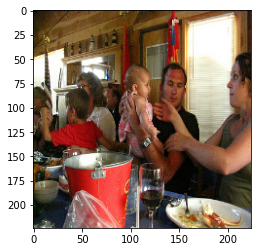

Predicted Caption:  a group of people are eating at a table


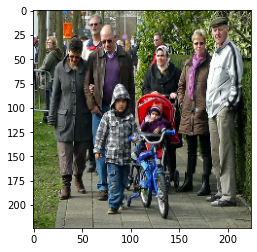

Predicted Caption:  a man in a blue jacket and a woman in a wheelchair


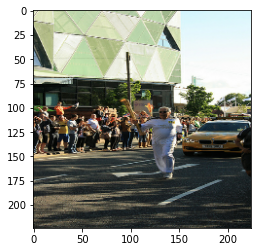

Predicted Caption:  a group of people are walking down the street


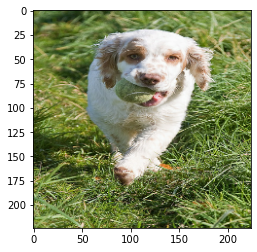

Predicted Caption:  a white dog is running through the grass


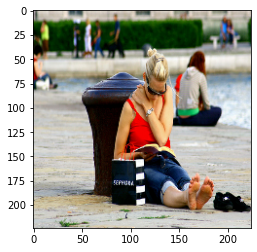

Predicted Caption:  a woman in a red shirt and a man in a black shirt and a black shirt is sitting on a bench


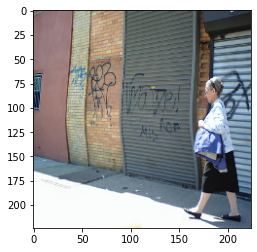

Predicted Caption:  a woman in a white shirt and black pants walking down the sidewalk


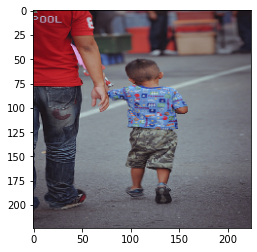

Predicted Caption:  a young boy in a red shirt and jeans is walking down the street


In [18]:
generate_caption()
generate_caption()
generate_caption()
generate_caption()
generate_caption()
generate_caption()
generate_caption()
generate_caption()
generate_caption()
generate_caption()
generate_caption()
generate_caption()
generate_caption()
generate_caption()